In [110]:
import psycopg2
from pyspark.sql import SparkSession
from pyspark.sql.functions import dayofweek
import json

import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("vis") \
    .config("spark.jars", "/home/jovyan/work/postgresql-42.2.23.jar") \
    .getOrCreate()

In [86]:
df = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://nyc_tripdata_db_1:5432/postgres") \
    .option("dbtable", "trips") \
    .option("user", "postgres") \
    .option("password", "postgres1234") \
    .option("driver", "org.postgresql.Driver") \
    .load()

In [87]:
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- vendor_name: string (nullable = true)
 |-- trip_pickup_datetime: timestamp (nullable = true)
 |-- trip_dropoff_datetime: timestamp (nullable = true)
 |-- trip_distance: decimal(5,2) (nullable = true)
 |-- start_lon: double (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- end_lon: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- trip_duration: decimal(10,0) (nullable = true)



In [88]:
df.count()

9998

### Data Cleaning
Delete rows when trip duration is negtive values.

In [89]:
df_negative = df.filter(df.trip_duration < 0)
df_negative.count()

195

In [90]:
df_negative.select(df.trip_pickup_datetime, df.trip_dropoff_datetime).show()

+--------------------+---------------------+
|trip_pickup_datetime|trip_dropoff_datetime|
+--------------------+---------------------+
| 2009-01-25 16:08:00|  2009-01-25 16:07:00|
| 2009-01-24 23:37:00|  2009-01-24 23:34:00|
| 2009-01-25 21:42:00|  2009-01-25 21:41:00|
| 2009-01-24 11:14:00|  2009-01-24 11:12:00|
| 2009-01-11 21:43:00|  2009-01-11 21:39:00|
| 2009-01-13 20:26:00|  2009-01-13 20:24:00|
| 2009-01-10 03:50:00|  2009-01-10 03:40:00|
| 2009-01-09 16:52:00|  2009-01-09 16:45:00|
| 2009-01-11 00:38:00|  2009-01-11 00:34:00|
| 2009-01-09 04:54:00|  2009-01-09 04:50:00|
| 2009-01-08 16:55:00|  2009-01-08 16:53:00|
| 2009-01-08 13:45:00|  2009-01-08 13:41:00|
| 2009-01-14 19:50:00|  2009-01-14 19:42:00|
| 2009-01-08 14:26:00|  2009-01-08 14:25:00|
| 2009-01-08 09:35:00|  2009-01-08 09:33:00|
| 2009-01-13 21:10:00|  2009-01-13 21:07:00|
| 2009-01-14 09:36:00|  2009-01-14 09:32:00|
| 2009-01-05 17:15:00|  2009-01-05 17:12:00|
| 2009-01-07 09:12:00|  2009-01-07 09:04:00|
| 2009-01-

In [91]:
df = df.filter(df.trip_duration >= 0)
df.count()

9803

### understanding our dataset by some visualization

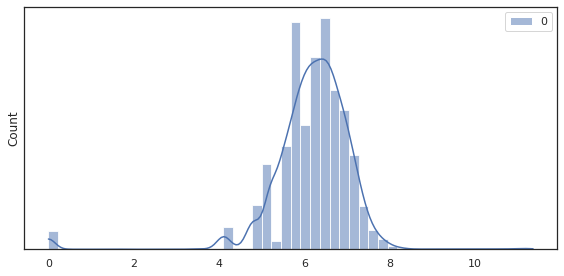

In [108]:
f, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.set(style="white")
sns.histplot(np.log(np.array(np.array(df.select('trip_duration').collect()).astype(int))+1),
             label = 'log(trip_duration)', 
             stat = 'count',
             bins = 50,
             kde=True)

plt.setp(ax, yticks=[])
plt.tight_layout()
plt.show()

In [182]:
tmp = df.withColumn('day', dayofweek('trip_pickup_datetime'))
tmp.select('day').show(5)

+---+
|day|
+---+
|  1|
|  1|
|  7|
|  5|
|  7|
+---+
only showing top 5 rows



In [183]:
wdays_avg_duration = tmp.groupBy("day")\
                        .mean('trip_duration') \
                        .withColumnRenamed("avg(trip_duration)", "avg") \
                        .orderBy('day')

In [184]:
wdays_avg_duration = np.array(wdays_avg_duration.collect()).astype(float)

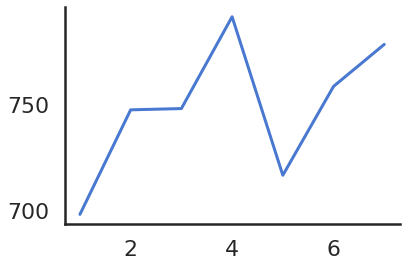

In [185]:
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.lineplot(x = wdays_avg_duration[:,0], y=wdays_avg_duration[:, 1])
sns.despine(bottom = False)